# Prequisite

*Prequisite Week 3 - Power of Data Scraping*

1. Download WebDriver (Edge/Chrome)  
https://developer.microsoft.com/en-us/microsoft-edge/tools/webdriver/?form=MA13LH  
https://developer.chrome.com/docs/chromedriver/downloads  
sesuaikan dengan versi browser masing-masing yang terinstall (bisa di cek di pengaturan browser)  
  
2. Basic Concept of HTML and CSS  
Karena kita nanti casenya web scraping, kita perlu tahu juga apa itu HTML dan CSS, salah satu refferensinya bisa cek link berikut  
https://www.hostinger.com/tutorials/what-is-html  
https://blog.lewagon.com/skills/what-is-css/  

# Import Library

In [31]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd

# Web Driver Configuration

In [32]:
# Pilih sesuai web browser
# options = webdriver.EdgeOptions()
options = webdriver.ChromeOptions() 
options.use_chromium = True
# options.add_argument("headless")  # Untuk menjalankan browser dalam mode headless
driver = webdriver.Edge(options=options)
wait = WebDriverWait(driver, 5)

# Determine Target Location

Akses Maps Menggunakan [Place Id](https://chromewebstore.google.com/detail/maps-place-id-search-tool/gdnnaahojechcmemagbbbbnoiieolafp) (Search Place Id Finder buat cari id dari lokasi)

<div style="display: flex;">
    <img src="https://i.ibb.co.com/ncgY5Kv/111.jpg" style="max-width: 50%;">
    <img src="https://i.ibb.co.com/vJX3mWP/222.jpg" style="max-width: 50%;">
</div>

In [33]:
tus_place_id = 'ChIJHVqSy9H71y0RnwWbLgvLvh0'
base_url = 'https://www.google.com/maps/place/?q=place_id:'
driver.get(f'{base_url}{tus_place_id}')

# Open Review Tab

In [34]:
# Get List of Tab Menu
list_menu = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.Gpq6kf.fontTitleSmall')))

# filter elemen berdasarkan teksnya dan berhenti pada yang pertama ditemukan
text_target = ['Ulasan', 'Rating'] # karena kan ada menu overview dan about (jadi kita pilih rating)
target_element = None
for el in list_menu:
    if el.text in text_target:
        target_element = el
        print('Tab Review Found')
        break

Tab Review Found


In [35]:
target_element.click()

# Scrool Sidebar

In [36]:
# Find Sidebar
sidebar = driver.find_element(By.CSS_SELECTOR, ".m6QErb.DxyBCb.kA9KIf.dS8AEf.XiKgde")
print(sidebar)

<selenium.webdriver.remote.webelement.WebElement (session="4f3c6ea3af01eaa416f7ff24bffd1875", element="f.31A5AFAA0109B193DB7C34880EAC0B35.d.B5DF655687FE8A82EB0F0B5B20C3648E.e.38")>


In [37]:
# Fungsi untuk menggulir sidebar ke bawah
def scroll_sidebar_to_bottom(time_sleep):
    # Ambil tinggi sidebar
    last_height = driver.execute_script("return arguments[0].scrollHeight;", sidebar)
    
    while True:
        # Gulir sidebar ke bawah
        driver.execute_script("arguments[0].scrollTo(0, arguments[0].scrollHeight);", sidebar)
        
        # Tunggu beberapa detik untuk memuat konten baru
        time.sleep(time_sleep)
        # Value Time Sleep Sesuaikan dengan koneksi dan device, bisa jadi bisa lebih cepat atau lambat untuk scrooling dan melakukan rendering content)
        
        # Hitung tinggi sidebar baru setelah menggulir
        new_height = driver.execute_script("return arguments[0].scrollHeight;", sidebar)
        
        # Jika tinggi sidebar baru sama dengan tinggi sebelumnya, berarti sudah mencapai bagian bawah
        if new_height == last_height:
            break
        
        last_height = new_height

# Panggil fungsi untuk menggulir sidebar sampai ke bawah
scroll_sidebar_to_bottom(2)

# Find the Element You Want to Scrape

<div style="text-align: center;">
    <img src="https://yourimageshare.com/ib/L9Su4s43Zv.webp" width="450">
</div>

`To scrape review URL, obtain the geo-coordinates manually in Google Maps by right-clicking near the red pin on the map`

>Don't worry, Google Map coordinates are not that strict. The important thing is to ensure that your coordinates are still within the scope of the location you're referring to

<div style="text-align: center;">
    <img src="https://i.ibb.co.com/1LvmxHG/Whats-App-Image-2024-05-17-at-22-22-29-c8e48943.jpg" width="400">
</div>

In [38]:
print(len(driver.find_elements(By.CSS_SELECTOR, 'div.d4r55')))
print(len(driver.find_elements(By.CSS_SELECTOR, 'div.RfnDt')))
print(len(driver.find_elements(By.CSS_SELECTOR, 'span.kvMYJc[aria-label*="bintang"]')))
print(len(driver.find_elements(By.CSS_SELECTOR, 'span.rsqaWe')))
print(len(driver.find_elements(By.CSS_SELECTOR, 'span.wiI7pd')))
print(len(driver.find_elements(By.CSS_SELECTOR, 'span.pkWtMe')))
print(len(driver.find_elements(By.CSS_SELECTOR, 'button.al6Kxe')))

254
230
254
254
108
72
254


In [39]:
for i in range(0, 5):
    print(driver.find_elements(By.CSS_SELECTOR, 'button.al6Kxe')[i].get_attribute('data-href'))

https://www.google.com/maps/contrib/103472688785147558501/reviews?hl=id
https://www.google.com/maps/contrib/110809995417901392155/reviews?hl=id
https://www.google.com/maps/contrib/112880635694197045058/reviews?hl=id
https://www.google.com/maps/contrib/114013628700700772575/reviews?hl=id
https://www.google.com/maps/contrib/116378066798139972794/reviews?hl=id


In [40]:
def get_digits(num, digit):
    return tuple(round(n, digit) for n in num)

`Adjust the geo-coordinate to your case` 

In [41]:
geo_coordinate = (get_digits((-7.3110645918643185, 112.72901710435903), 6)) 
review_id_test = driver.find_element(By.CLASS_NAME, 'jftiEf').get_attribute('data-review-id')
base_review_url = f'https://www.google.com/maps/reviews/@{geo_coordinate[0]},{geo_coordinate[1]},17z/data=!3m1!4b1!4m6!14m5!1m4!2m3!1s{review_id_test}!2m1!1s0x0:0x4ceb8bb356c12235?hl=id&entry=ttu'
print(base_review_url)

https://www.google.com/maps/reviews/@-7.311065,112.729017,17z/data=!3m1!4b1!4m6!14m5!1m4!2m3!1sChZDSUhNMG9nS0VJQ0FnSUNKd1BtQkNREAE!2m1!1s0x0:0x4ceb8bb356c12235?hl=id&entry=ttu


# Get Card Comments > Looping > Scrape All 

In [42]:
def extract_status(string):
    parts = string.split("·")
    # ['Local Guide', '378 ulasan','1.954 foto']
    
    guide_type = 'Non Local Guide'
    review_count = None
    photo_count = None

    for part in parts:
        clean_part = part.strip().split()
        # ['1.954', 'ulasan']
        if any(word in clean_part for word in ['review', 'ulasan']):
            review_count = int(clean_part[0].replace('.',''))
        elif any(word in clean_part for word in ['photo', 'foto']):
            photo_count = int(clean_part[0].replace('.',''))
        else:
            # Jika tidak mengandung kata 'ulasan' atau 'foto', itu mungkin menjadi tipe guide
            guide_type = ' '.join(clean_part)

    # print(guide_type, "\t", review_count, "\t", photo_count)
    return guide_type, review_count, photo_count


In [43]:
print(extract_status('Local Guide · 378 ulasan · 1.954 foto'))
print(extract_status('378 ulasan · 1.954 foto'))
print(extract_status('1.954 foto'))

('Local Guide', 378, 1954)
('Non Local Guide', 378, 1954)
('Non Local Guide', None, 1954)


In [44]:
names = []
status = [] # To be parsed by type of guide (local/non-local) | number of reviews | number of photos
guide_types = []
guide_review_count = []
guide_photo_count = []
rating = []
rating_dates = []
descriptions = []
likes = []
profile_links = []
review_links = []


comment_cards = driver.find_elements(By.CSS_SELECTOR, 'div.jftiEf')
for i, cc in enumerate(comment_cards):
    # print(i)
    names.append(cc.find_element(By.CSS_SELECTOR, 'div.d4r55').text)
    
    try:
        st = cc.find_element(By.CSS_SELECTOR, 'div.RfnDt').text
        g_type, g_review_count, g_photo_count = extract_status(st)
        guide_types.append(g_type)
        guide_review_count.append(g_review_count)
        guide_photo_count.append(g_photo_count)
    except:
        err_val = '-'
        guide_types.append(err_val)
        guide_review_count.append(err_val)
        guide_photo_count.append(err_val)
        
    rating.append(cc.find_element(By.CSS_SELECTOR, 'span.kvMYJc[aria-label*="bintang"]').get_attribute("aria-label").split()[0])
    rating_dates.append(cc.find_element(By.CSS_SELECTOR, 'span.rsqaWe').text)
    
    try:
        dsc = cc.find_element(By.CSS_SELECTOR, 'span.wiI7pd').text
        descriptions.append(dsc)
    except:
        descriptions.append("-")
    
    try:
        like = cc.find_element(By.CSS_SELECTOR, 'span.pkWtMe').text
        likes.append(like)
    except:
        likes.append(0)
        
    profile_links.append(cc.find_element(By.CSS_SELECTOR, 'button.al6Kxe').get_attribute("data-href"))
    try:
        review_id = cc.get_attribute('data-review-id')
        base_review_url = f'https://www.google.com/maps/reviews/@{geo_coordinate[0]},{geo_coordinate[1]},17z/data=!3m1!4b1!4m6!14m5!1m4!2m3!1s{review_id}!2m1!1s0x0:0x4ceb8bb356c12235?hl=id&entry=ttu'
        review_links.append(base_review_url)
    except:
        print('REVIEW ID ERROR')
    

`use try and catch to handle unavailable element`

In [45]:
print(len(names))
print(len(guide_types))
print(len(guide_review_count))
print(len(guide_photo_count))
print(len(rating))
print(len(rating_dates))
print(len(descriptions))
print(len(likes))
print(len(profile_links))
print(len(review_links))

254
254
254
254
254
254
254
254
254
254


In [46]:
datas = [names, guide_types, guide_review_count, guide_photo_count, rating, rating_dates, descriptions, likes, profile_links, review_links]
for d in datas:
    print(d[-1])

si itts
-
-
-
5
5 tahun lalu
-
0
https://www.google.com/maps/contrib/107267306127338838156/reviews?hl=id
https://www.google.com/maps/reviews/@-7.311065,112.729017,17z/data=!3m1!4b1!4m6!14m5!1m4!2m3!1sChdDSUhNMG9nS0VJQ0FnSUNvMEpuZml3RRAB!2m1!1s0x0:0x4ceb8bb356c12235?hl=id&entry=ttu


# BINGO :> :> :> :> :>

# Export 

In [47]:
import pandas as pd

In [48]:
data = {
    'name': names,
    'guide_type': guide_types,
    'guide_review_count': guide_review_count,
    'guide_photo_count': guide_photo_count,
    'rating': rating,
    'rating_date': rating_dates,
    'description': descriptions,
    'likes': likes,
    'profile_link': profile_links,
    'review_link': review_links
}

df = pd.DataFrame(data)
df.head()

,name,guide_type,guide_review_count,guide_photo_count,rating,rating_date,description,likes,profile_link,review_link
0,Adi Prasetyo,Local Guide,378,1969,5,setahun lalu,Salah satu kampus it telkom di daerah strategi...,6,https://www.google.com/maps/contrib/1034726887...,https://www.google.com/maps/reviews/@-7.311065...
1,A.R. Bagas Danang Haditio,Local Guide,78,763,1,6 bulan lalu,Kangen suasana shalt ied di lapangan Telkom td...,2,https://www.google.com/maps/contrib/1108099954...,https://www.google.com/maps/reviews/@-7.311065...
2,mutmainnah salaminna,Non Local Guide,2,1,5,2 minggu lalu,Murid saya ada yg kuliah disini... Baru aja lu...,0,https://www.google.com/maps/contrib/1128806356...,https://www.google.com/maps/reviews/@-7.311065...
3,VividMUA,Non Local Guide,7,None,5,2 bulan lalu,"Kampusnya adem, Semoga Telkom University menin...",1,https://www.google.com/maps/contrib/1140136287...,https://www.google.com/maps/reviews/@-7.311065...
4,Rosyid Abdillah,Local Guide,9,34,5,setahun lalu,salah satu opsi terbaik untuk studi lanjut dib...,5,https://www.google.com/maps/contrib/1163780667...,https://www.google.com/maps/reviews/@-7.311065...


In [49]:
df['rating_date'].value_counts()

rating_date
2 tahun lalu     80
setahun lalu     56
3 tahun lalu     23
4 tahun lalu     14
2 bulan lalu     10
9 bulan lalu      8
3 bulan lalu      8
5 tahun lalu      7
8 bulan lalu      7
5 bulan lalu      6
6 tahun lalu      6
sebulan lalu      6
4 bulan lalu      6
6 bulan lalu      4
10 bulan lalu     4
seminggu lalu     2
3 minggu lalu     2
7 bulan lalu      2
2 minggu lalu     1
4 minggu lalu     1
11 bulan lalu     1
Name: count, dtype: int64

In [50]:
df.to_csv('gugel_mep.csv', index=False)

# Note: Pay attention to the language you use (to select and filtering data)

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                254 non-null    object
 1   guide_type          254 non-null    object
 2   guide_review_count  245 non-null    object
 3   guide_photo_count   185 non-null    object
 4   rating              254 non-null    object
 5   rating_date         254 non-null    object
 6   description         254 non-null    object
 7   likes               254 non-null    object
 8   profile_link        254 non-null    object
 9   review_link         254 non-null    object
dtypes: object(10)
memory usage: 20.0+ KB


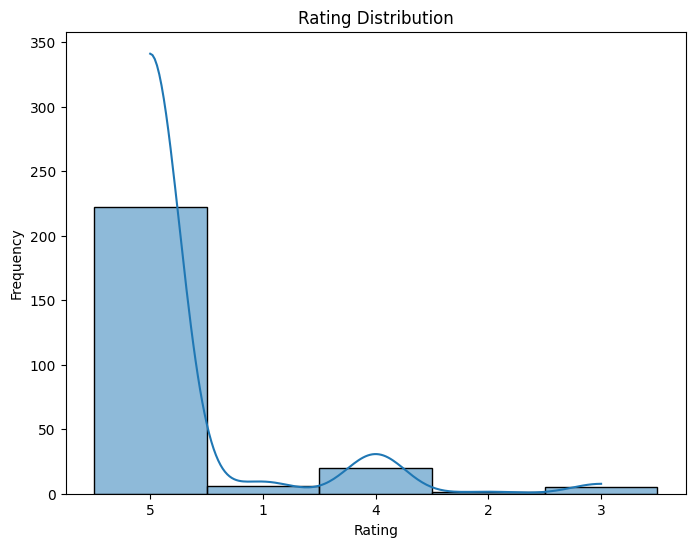

In [52]:
# Step 1: Basic Info and Summary
df_info = df.info()
df_summary = df.describe(include='all')

# Step 2: Guide Type Distribution
guide_type_counts = df['guide_type'].value_counts()

# Step 3: Rating Distribution Plot
plt.figure(figsize=(8, 6))
sns.histplot(df['rating'], bins=5, kde=True)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [53]:
from datetime import datetime, timedelta
import numpy as np

# Function to parse relative time expressions
def normalize_rating_date(date_str):
    if 'setahun lalu' in date_str:
        return datetime.now() - timedelta(days=365)
    elif 'sebulan lalu' in date_str:
        return datetime.now() - timedelta(days=30)
    elif 'seminggu lalu' in date_str:
        return datetime.now() - timedelta(weeks=1)
    elif 'sehari lalu' in date_str:
        return datetime.now() - timedelta(days=1)
    elif 'tahun lalu' in date_str:
        years_ago = int(date_str.split()[0])
        return datetime.now() - timedelta(days=years_ago * 365)
    elif 'bulan lalu' in date_str:
        months_ago = int(date_str.split()[0])
        return datetime.now() - timedelta(days=months_ago * 30)
    elif 'minggu lalu' in date_str:
        weeks_ago = int(date_str.split()[0])
        return datetime.now() - timedelta(weeks=weeks_ago)
    elif 'hari lalu' in date_str:
        days_ago = int(date_str.split()[0])
        return datetime.now() - timedelta(days=days_ago)
    else:
        return np.nan  # Set NaN for unparseable dat
    
# Apply normalization function to rating_date
df['normalized_rating_date'] = df['rating_date'].apply(normalize_rating_date)


In [54]:
df['normalized_rating_date'].head()

0   2023-10-27 11:05:37.379183
1   2024-04-29 11:05:37.379183
2   2024-10-12 11:05:37.379183
3   2024-08-27 11:05:37.379183
4   2023-10-27 11:05:37.379183
Name: normalized_rating_date, dtype: datetime64[ns]

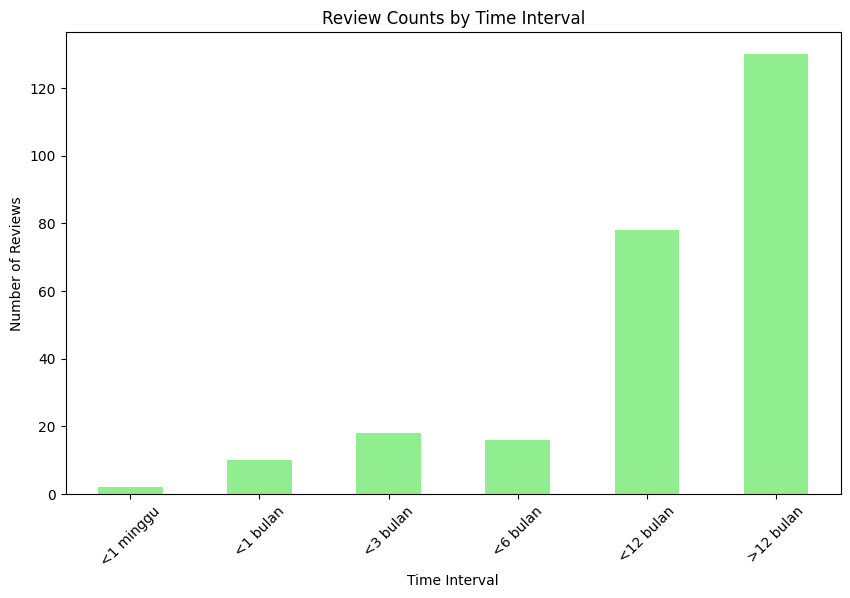

In [55]:
# Calculate the difference in days from today
df['days_diff'] = (datetime.now() - df['normalized_rating_date']).dt.days

# Define bins and labels for the specified intervals
bins = [0, 7, 30, 90, 180, 365, float('inf')]
labels = ['<1 minggu', '<1 bulan', '<3 bulan', '<6 bulan', '<12 bulan', '>12 bulan']

# Create a new column with the binned categories
df['time_category'] = pd.cut(df['days_diff'], bins=bins, labels=labels)

# Count the number of reviews in each category
time_category_counts = df['time_category'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(10, 6))
time_category_counts.plot(kind='bar', color='lightgreen')
plt.title('Review Counts by Time Interval')
plt.xlabel('Time Interval')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

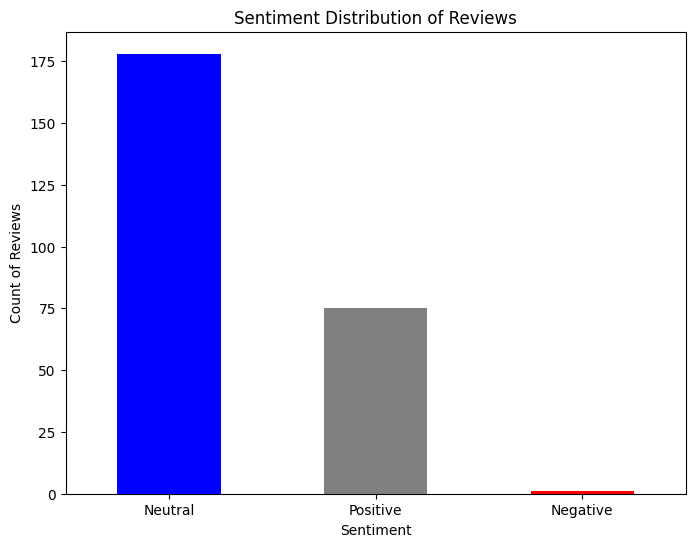

In [60]:
from googletrans import Translator
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the translator
translator = Translator()

# Function to translate text to English and classify sentiment
def classify_sentiment(text):
    try:
        # Translate to English
        translated_text = translator.translate(text, dest='en').text
        analysis = TextBlob(translated_text)
        # Classify sentiment
        if analysis.sentiment.polarity > 0:
            return "Positive"
        elif analysis.sentiment.polarity == 0:
            return "Neutral"
        else:
            return "Negative"
    except Exception as e:
        print(f"Translation error for text: {text} - {e}")
        return "Neutral"

# Apply the function to the 'description' column
df['sentiment'] = df['description'].apply(classify_sentiment)

# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['blue', 'grey', 'red'])
plt.title("Sentiment Distribution of Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count of Reviews")
plt.xticks(rotation=0)
plt.show()


# How to Easy Scrapping Website?
# `Understand the Structure of Website (Inspect Element is the Key :>)`

### Build by Whisnumurty Galih Ananta

### Find me  
- [LinkedIn](https://www.linkedin.com/in/whisnumurtyga/)
- [GitHub](https://github.com/whisnumurtyga)